# Import modules & packpackages

In [26]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import pearsonr
from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import gensim.downloader as api
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle

# Global Constants & Configuration

In [16]:
SENTENCES2_TSV = 'sentences2.tsv'
SENTENCES3_TSV = 'sentences3.tsv'
LABELS1_TSV = 'labels1.tsv'
LABELS2_TSV = 'labels2.tsv'
DICTIONARY_FILENAME = "/Users/mia/Library/Mobile Documents/com~apple~CloudDocs/杜伦/Term 3/毕业论文/字典内容/Refined_dictionary.txt"

VALUE_COLUMN_GROUPS = {
    'SD': ['Self-direction: thought attained', 'Self-direction: thought constrained', 'Self-direction: action attained', 'Self-direction: action constrained'],
    'ST': ['Stimulation attained', 'Stimulation constrained'], 'HE': ['Hedonism attained', 'Hedonism constrained'],
    'AC': ['Achievement attained', 'Achievement constrained'],
    'PO': ['Power: dominance attained', 'Power: dominance constrained', 'Power: resources attained', 'Power: resources constrained'],
    'SE': ['Security: personal attained', 'Security: personal constrained', 'Security: societal attained', 'Security: societal constrained'],
    'TR': ['Tradition attained', 'Tradition constrained'],
    'CO': ['Conformity: rules attained', 'Conformity: rules constrained', 'Conformity: interpersonal attained', 'Conformity: interpersonal constrained'],
    'BE': ['Benevolence: caring attained', 'Benevolence: caring constrained', 'Benevolence: dependability attained', 'Benevolence: dependability constrained'],
    'UN': ['Universalism: concern attained', 'Universalism: concern constrained', 'Universalism: nature attained', 'Universalism: nature constrained', 'Universalism: tolerance attained', 'Universalism: tolerance constrained']
}
ALL_VALUE_TYPES = list(VALUE_COLUMN_GROUPS.keys())

NUM_TOPICS = 10
TOPIC_TO_VALUE_MAP = {
    'PO': [8], 'SE': [5], 'CO': [0, 9], 'UN': [6],
    'BE': [3], 'AC': [2, 4], 'SD': [7], 'TR': [1],
    'HE': [], 'ST': []
}

# Data Loading & Preprocessing Functions

In [17]:
def download_nltk_data():
    print("downloading NLTK...")
    packages = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']
    for package in packages:
        try:
            nltk.data.find(f'tokenizers/{package}' if package == 'punkt' else f'corpora/{package}' if package in ['stopwords', 'wordnet'] else f'taggers/{package}')
        except LookupError:
            nltk.download(package)
    print("All the necessary NLTK data is now available.")

def load_glove_model():
    print("Loading glove-wiki-gigaword-100...")
    try:
        return api.load('glove-wiki-gigaword-100')
    except Exception as e:
        print(f"The model cannot be loaded. Please ensure that the network connection is normal. Error:{e}")
        exit()

def read_pvd_dictionary(filepath):
    value_mapping, pvd_dict = {}, {}
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            in_header = False
            for line in f:
                line = line.strip()
                if not line: continue
                if line == '%':
                    in_header = not in_header
                    continue
                if in_header:
                    num_str, value_str = line.split('\t')
                    value_mapping[num_str] = value_str.replace('Values_', '')
                else:
                    word, num_str = line.split('\t')
                    if num_str in value_mapping:
                        value_category = value_mapping[num_str]
                        pvd_dict.setdefault(value_category, set()).add(word.split('#')[0])
        return pvd_dict
    except FileNotFoundError:
        print(f"Error: Dictionary file not found: {filepath}. Please check the file path.")
        exit()

def load_and_prepare_data():
    try:
        sentence_df1 = pd.read_csv(SENTENCES2_TSV, sep='\t')
        sentence_df2 = pd.read_csv(SENTENCES3_TSV, sep='\t')
        sentences_df = pd.concat([sentence_df1, sentence_df2], ignore_index=True).sort_values(by=['Text-ID', 'Sentence-ID'])

        value_df1 = pd.read_csv(LABELS1_TSV, sep='\t')
        value_df2 = pd.read_csv(LABELS2_TSV, sep='\t')
        valueML_df = pd.concat([value_df1, value_df2], ignore_index=True)
    except FileNotFoundError as e:
        print(f"Error: Dictionary file not found: {e.filename}. Please check the file path.")
        exit()

    professional_df = valueML_df[['Text-ID', 'Sentence-ID']].copy()
    for main_label, sub_columns in VALUE_COLUMN_GROUPS.items():
        professional_df[main_label] = valueML_df[sub_columns].sum(axis=1, skipna=True)
    
    print(f"The text data has been loaded with {len(sentences_df)} records.")
    print(f"The expert scoring data has processed {len(professional_df)} records.")

    parsed_pvd = read_pvd_dictionary(DICTIONARY_FILENAME)
    print(f"The PVD dictionary has been loaded. There are a total of {sum(len(v) for v in parsed_pvd.values())} entries.")

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        return text

    sentences_df['Cleaned_Text'] = sentences_df['Text'].apply(clean_text)
    
    master_df = pd.merge(sentences_df, professional_df, on=['Text-ID', 'Sentence-ID'])
    master_df.dropna(subset=ALL_VALUE_TYPES, inplace=True)
    print(f"The main data frame has been created and aligned, with a total of {len(master_df)} records.")

    aggregated_pvd = {abbr: set() for abbr in ALL_VALUE_TYPES}
    for category, words in parsed_pvd.items():
        if category in aggregated_pvd:
            aggregated_pvd[category].update(words)
    print("The dictionary has been aggregated according to the expert rating columns.")
    
    return master_df, aggregated_pvd

# LDA Optimal K-Value Tuning

Start loading and preprocessing the data for LDA tuning...
downloading NLTK...
All the necessary NLTK data is now available.
The text data has been loaded with 59662 records.
The expert scoring data has processed 59662 records.
The PVD dictionary has been loaded. There are a total of 1068 entries.


[nltk_data] Downloading package wordnet to /Users/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The main data frame has been created and aligned, with a total of 59662 records.
The dictionary has been aggregated according to the expert rating columns.
The data loading is complete, with a total of 59662 records used for tuning.
The text corpus is being processed for LDA...
The text processing is completed.

Start calculating the Coherence and Perplexity scores for different K values...
  > Training LDA model with k=5...
  > Training LDA model with k=10...
  > Training LDA model with k=15...
  > Training LDA model with k=20...
  > Training LDA model with k=25...
  > Training LDA model with k=30...
  > Training LDA model with k=35...
  > Training LDA model with k=40...
  > Training LDA model with k=45...
  > Training LDA model with k=50...

Generating the K value selection chart...


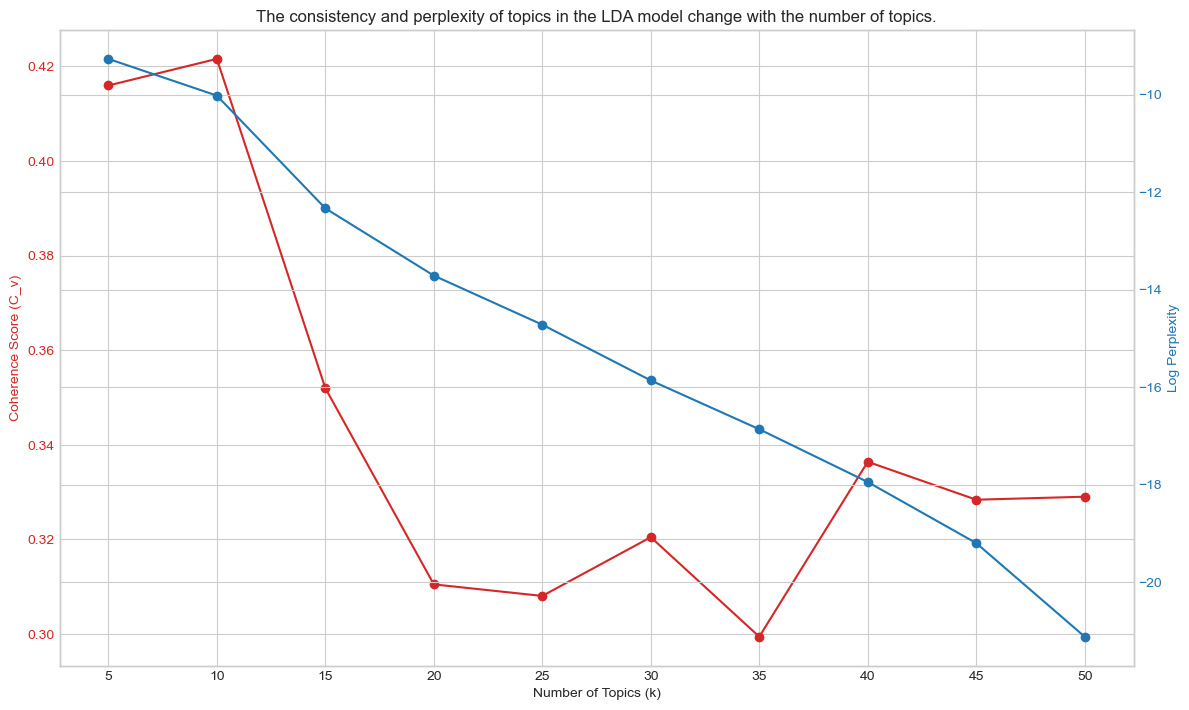


The scores corresponding to each K value:
k = 5: Coherence = 0.4160, Log Perplexity = -9.2684
k = 10: Coherence = 0.4216, Log Perplexity = -10.0212
k = 15: Coherence = 0.3519, Log Perplexity = -12.3340
k = 20: Coherence = 0.3104, Log Perplexity = -13.7142
k = 25: Coherence = 0.3080, Log Perplexity = -14.7213
k = 30: Coherence = 0.3204, Log Perplexity = -15.8653
k = 35: Coherence = 0.2994, Log Perplexity = -16.8665
k = 40: Coherence = 0.3364, Log Perplexity = -17.9493
k = 45: Coherence = 0.3283, Log Perplexity = -19.2023
k = 50: Coherence = 0.3290, Log Perplexity = -21.1223

Based on the highest Coherence Score, the recommended optimal K value is: 10

The LDA tuning results are being saved to a file 'results/lda_tuning_results.pkl'...
Save successfully.


In [28]:
print("Start loading and preprocessing the data for LDA tuning...")
download_nltk_data()
master_df, _ = load_and_prepare_data()
corpus = master_df['Cleaned_Text'].tolist()
print(f"The data loading is complete, with a total of {len(corpus)} records used for tuning.")

print("The text corpus is being processed for LDA...")
tokenized_texts_lda_tuning = [process_corpus_text(doc, 'exact', remove_stopwords=True) for doc in corpus]
id2word = corpora.Dictionary(tokenized_texts_lda_tuning)
gensim_corpus = [id2word.doc2bow(text) for text in tokenized_texts_lda_tuning]
print("The text processing is completed.")

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    perplexity_values = []
    k_values = range(start, limit + 1, step)
    for k in k_values:
        print(f"  > Training LDA model with k={k}...")
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100,
                                           chunksize=100, passes=10, per_word_topics=True)
        perplexity_values.append(model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values, perplexity_values, list(k_values)

print("\nStart calculating the Coherence and Perplexity scores for different K values...")
coherence, perplexity, k_vals = compute_coherence_values(
    dictionary=id2word, corpus=gensim_corpus, texts=tokenized_texts_lda_tuning, start=5, limit=50, step=5
)

print("\nGenerating the K value selection chart...")
try:
    fig, ax1 = plt.subplots(figsize=(12, 7))
    color = 'tab:red'
    ax1.set_xlabel('Number of Topics (k)')
    ax1.set_ylabel('Coherence Score (C_v)', color=color)
    ax1.plot(k_vals, coherence, 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(k_vals)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Log Perplexity', color=color)
    ax2.plot(k_vals, perplexity, 'o-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()
    plt.title('The consistency and perplexity of topics in the LDA model change with the number of topics.')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"\n[Error] LDA tuning graph cannot be generated: {e}")

print("\nThe scores corresponding to each K value:")
optimal_k = 0
max_coherence = -1
for i, k in enumerate(k_vals):
    print(f"k = {k}: Coherence = {coherence[i]:.4f}, Log Perplexity = {perplexity[i]:.4f}")
    if coherence[i] > max_coherence:
        max_coherence = coherence[i]
        optimal_k = k
        
print(f"\nBased on the highest Coherence Score, the recommended optimal K value is: {optimal_k}")

print("\nThe LDA tuning results are being saved to a file 'results/lda_tuning_results.pkl'...")
os.makedirs('results', exist_ok=True)  # 创建一个名为 'results' 的文件夹（如果不存在）
with open('results/lda_tuning_results.pkl', 'wb') as f:
    pickle.dump({'coherence': coherence, 'perplexity': perplexity, 'k_vals': k_vals}, f)
print("Save successfully.")

# Text Processing & Scoring Functions

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def process_corpus_text(cleaned_text, strategy='exact', remove_stopwords=False):
    tokens = word_tokenize(cleaned_text)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    if strategy == 'stem':
        return [stemmer.stem(word) for word in tokens]
    elif strategy == 'lemmatize':
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    elif strategy == 'exact':
        return tokens
    else:
        raise ValueError("Unknown tokenization")

def calculate_raw_scores(processed_corpus_tokens, pvd_dict, vec_tech, glove_vectors, vectorizer_model=None, binary_score=True):
    num_docs = len(processed_corpus_tokens)
    scores = pd.DataFrame(0.0, index=range(num_docs), columns=pvd_dict.keys())

    if vec_tech == 'embedding_similarity':
        value_vectors = {
            value: np.mean([glove_vectors[word] for word in keywords if word in glove_vectors], axis=0).reshape(1, -1)
            for value, keywords in pvd_dict.items() if any(word in glove_vectors for word in keywords)
        }
        if not value_vectors: return scores

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_word_vectors = [glove_vectors[token] for token in doc_tokens if token in glove_vectors]
            if not doc_word_vectors: continue
            doc_vector = np.mean(doc_word_vectors, axis=0).reshape(1, -1)
            for value, value_vec in value_vectors.items():
                scores.at[i, value] = cosine_similarity(doc_vector, value_vec)[0][0]

    elif vec_tech == 'embedding_counting':
        pvd_centroids = {
            value: np.mean([glove_vectors[word] for word in keywords if word in glove_vectors], axis=0)
            for value, keywords in pvd_dict.items() if any(word in glove_vectors for word in keywords)
        }
        if not pvd_centroids: return scores

        value_labels = list(pvd_centroids.keys())
        centroid_matrix = np.array([pvd_centroids[label] for label in value_labels])
        threshold = 0.4

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_scores = Counter()
            for token in doc_tokens:
                if token in glove_vectors:
                    token_vec = glove_vectors[token].reshape(1, -1)
                    similarities = cosine_similarity(token_vec, centroid_matrix)[0]
                    max_sim_idx = np.argmax(similarities)
                    if similarities[max_sim_idx] > threshold:
                        doc_scores[value_labels[max_sim_idx]] += 1
            for value, score in doc_scores.items():
                scores.at[i, value] = 1 if score > 0 else 0

    elif vec_tech in ['bow', 'tfidf_binary', 'tfidf_continuous']:
        vocab_map = vectorizer_model.vocabulary_
        doc_term_matrix = vectorizer_model.transform([" ".join(doc) for doc in processed_corpus_tokens]).toarray()
        for value, keywords in pvd_dict.items():
            keyword_indices = [vocab_map[word] for word in keywords if word in vocab_map]
            if not keyword_indices: continue
            
            value_scores = doc_term_matrix[:, keyword_indices].sum(axis=1)
            scores[value] = (value_scores > 0).astype(int) if binary_score else value_scores

    return scores

def ipsatise_scores(raw_scores_df):
    mean_scores = raw_scores_df.mean(axis=1)
    return raw_scores_df.subtract(mean_scores, axis=0)

# Evaluation Functions

In [22]:
def evaluate_performance(automated_scores, expert_scores, binarize_rule="gt0", topk=1):
    metrics = {}
    correlations = {}
    
    for value_dim in automated_scores.columns:
        auto_series = automated_scores[value_dim]
        expert_series = expert_scores[value_dim].reset_index(drop=True)
        if auto_series.std() > 0 and expert_series.std() > 0:
            corr, _ = pearsonr(auto_series, expert_series)
            correlations[value_dim] = corr if not np.isnan(corr) else 0.0
        else:
            correlations[value_dim] = 0.0
    
    metrics['dimensional_correlation'] = correlations
    metrics['avg_dimensional_correlation'] = np.mean(list(correlations.values()))
    metrics['dimensional_correlation_std'] = np.std(list(correlations.values()))

    profile_corrs = [
        pearsonr(auto_row, expert_row)[0] if pd.Series(auto_row).std() > 0 and pd.Series(expert_row).std() > 0 else 0.0
        for auto_row, expert_row in zip(automated_scores.itertuples(index=False), expert_scores.itertuples(index=False))
    ]
    
    valid_profile_corrs = [c for c in profile_corrs if not np.isnan(c)]
    metrics['avg_profile_correlation'] = np.mean(valid_profile_corrs)
    metrics['profile_correlation_std'] = np.std(valid_profile_corrs)
    
    metrics['mae'] = mean_absolute_error(expert_scores, automated_scores)
    metrics['rmse'] = np.sqrt(mean_squared_error(expert_scores, automated_scores))

    y_true = (expert_scores.values > 0).astype(int)
    
    if binarize_rule == "gt0":
        y_pred = (automated_scores.values > 0).astype(int)
    elif binarize_rule == "ge1":
        y_pred = (automated_scores.values >= 1).astype(int)
    elif binarize_rule == "topk":
        y_pred = np.zeros_like(automated_scores.values, dtype=int)
        topk_idx = np.argsort(-automated_scores.values, axis=1)[:, :topk]
        rows = np.arange(automated_scores.shape[0])[:, None]
        y_pred[rows, topk_idx] = 1
    else:
        raise ValueError("Unknown binarization")

    for avg in ["micro", "macro", "weighted"]:
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
        metrics[f"{avg}_precision"] = p
        metrics[f"{avg}_recall"] = r
        metrics[f"{avg}_f1"] = f1
        
    return metrics, y_true, y_pred


from sklearn.utils import resample

def bootstrap_confidence_intervals(automated_scores, expert_scores, n_iterations=1000, alpha=0.95):
    stats = []
    n_samples = len(automated_scores)
    for i in range(n_iterations):
        indices = resample(np.arange(n_samples))
        boot_auto = automated_scores.iloc[indices]
        boot_expert = expert_scores.iloc[indices]
        
        perf, _, _ = evaluate_performance(boot_auto, boot_expert)
        stats.append(perf['avg_dimensional_correlation'])
    
    lower_bound = np.percentile(stats, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(stats, (alpha + (1 - alpha) / 2) * 100)
    
    return lower_bound, upper_bound

def significance_test_correlation(scores1, scores2, expert_scores, n_permutations=1000):
    perf1, _, _ = evaluate_performance(scores1, expert_scores)
    perf2, _, _ = evaluate_performance(scores2, expert_scores)
    observed_diff = perf1['avg_dimensional_correlation'] - perf2['avg_dimensional_correlation']
    
    n_samples = len(scores1)
    perm_diffs = []
    
    for i in range(n_permutations):
        mask = np.random.rand(n_samples) < 0.5
        perm_scores1 = pd.DataFrame(np.where(mask[:, None], scores1, scores2), columns=scores1.columns)
        perm_scores2 = pd.DataFrame(np.where(mask[:, None], scores2, scores1), columns=scores2.columns)

        perm_perf1, _, _ = evaluate_performance(perm_scores1, expert_scores)
        perm_perf2, _, _ = evaluate_performance(perm_scores2, expert_scores)
        perm_diffs.append(perm_perf1['avg_dimensional_correlation'] - perm_perf2['avg_dimensional_correlation'])
        
    # 计算 p-value
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# Main Experiment

In [29]:
def run_experiment(master_df, aggregated_pvd, glove_vectors):
    tokenization_strategies = ['exact', 'stem', 'lemmatize']
    vectorization_techniques = ['bow', 'tfidf_binary', 'tfidf_continuous', 'embedding_similarity', 'embedding_counting', 'lda']
    
    results = []
    all_scores = {}
    
    best_score = -np.inf
    best_config_name = None
    
    corpus = master_df['Cleaned_Text'].tolist()
    expert_scores_df = master_df[ALL_VALUE_TYPES]

    print("\nThe corpus is being preprocessed for all word segmentation strategies")
    processed_corpora = {}
    for strat in tokenization_strategies:
        processed_corpora[strat] = {
            'with_stopwords': [process_corpus_text(doc, strat, remove_stopwords=True) for doc in corpus],
            'no_stopwords': [process_corpus_text(doc, strat, remove_stopwords=False) for doc in corpus]
        }
    print("Corpus preprocessed")
    
    print("\nStart 3x6 factor experiment")
    for token_strat in tokenization_strategies:
        print(f"\n--- Tokenization: {token_strat.upper()} ---")
        
        processed_pvd = {val: [process_corpus_text(w, token_strat)[0] for w in words] for val, words in aggregated_pvd.items()}
        
        pvd_vocabulary = sorted(list(set(word for words in processed_pvd.values() for word in words)))
        bow_vectorizer = CountVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b").fit([" ".join(doc) for doc in processed_corpora[token_strat]['no_stopwords']])
        tfidf_vectorizer = TfidfVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b").fit([" ".join(doc) for doc in processed_corpora[token_strat]['no_stopwords']])

        for vec_tech in vectorization_techniques:
            print(f"  > Vectorization: {vec_tech.upper()}")
            
            raw_scores = pd.DataFrame()
            combo_name = f"{token_strat}_{vec_tech}"
            
            if vec_tech == 'lda':
                lda_corpus = processed_corpora[token_strat]['with_stopwords']
                lda_vectorizer = CountVectorizer(max_df=0.95, min_df=5)
                doc_term_matrix_lda = lda_vectorizer.fit_transform([" ".join(doc) for doc in lda_corpus])
                
                if doc_term_matrix_lda.shape[1] == 0: continue
                
                lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
                doc_topic_dist = lda_model.fit_transform(doc_term_matrix_lda)
                
                scores_df_lda_raw = pd.DataFrame(doc_topic_dist, columns=[f'Topic_{i}' for i in range(NUM_TOPICS)])
                raw_scores = pd.DataFrame(index=scores_df_lda_raw.index, columns=ALL_VALUE_TYPES).fillna(0)
                for value, topic_indices in TOPIC_TO_VALUE_MAP.items():
                    if topic_indices:
                        relevant_topics = [f'Topic_{i}' for i in topic_indices]
                        raw_scores[value] = scores_df_lda_raw[relevant_topics].sum(axis=1)
            else:
                current_corpus = processed_corpora[token_strat]['no_stopwords']
                vectorizer, binary_score = None, True
                if vec_tech == 'bow': vectorizer = bow_vectorizer
                elif 'tfidf' in vec_tech:
                    vectorizer = tfidf_vectorizer
                    if 'continuous' in vec_tech: binary_score = False

                raw_scores = calculate_raw_scores(current_corpus, processed_pvd, vec_tech, glove_vectors, vectorizer, binary_score)
            
            automated_ipsatised = ipsatise_scores(raw_scores)
            expert_ipsatised = ipsatise_scores(expert_scores_df)
            all_scores[combo_name] = {'raw': raw_scores, 'ipsatised': automated_ipsatised}
            

            performance, _, _ = evaluate_performance(automated_ipsatised, expert_ipsatised, binarize_rule='gt0')
            current_score = performance['avg_dimensional_correlation']
            if not np.isnan(current_score) and current_score > best_score:
                best_score = current_score
                best_config_name = combo_name

            for rule in ["gt0", "ge1", "topk"]:
                perf, _, _ = evaluate_performance(automated_ipsatised, expert_ipsatised, binarize_rule=rule)
                results.append({
                    'tokenization': token_strat, 'vectorization': vec_tech, 'binarize_rule': rule, **perf
                })

    print("\nExperiment Finished")
    return pd.DataFrame(results), all_scores, expert_scores_df, best_config_name

# Results Analysis & Visualization Functions

In [ ]:
def plot_best_model_scatter(best_config_name, all_scores, expert_scores_df, 
                            nrows=2, ncols=5, figsize=(25, 10)):
    print(f"\nGenerate the original fractional scatter plot for the best model {best_config_name}...")

    if best_config_name not in all_scores:
        print(f"[Error] Scores cannot be found for the best model {best_config_name}.")
        return

    original_raw_scores_df = all_scores[best_config_name]['raw']
    raw_expert_scores_df = expert_scores_df.copy()

    if original_raw_scores_df is not None:
        comparison_df_perf = pd.concat([original_raw_scores_df.add_prefix('Automated_'), raw_expert_scores_df.add_prefix('Expert_')], axis=1)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axes = axes.flatten()

        for i, value in enumerate(ALL_VALUE_TYPES):
            if i < len(axes):
                ax = axes[i]
                sns.scatterplot(data=comparison_df_perf, x=f'Expert_{value}', y=f'Automated_{value}', alpha=0.3, ax=ax)
                ax.set_title(f"Value: {value}")
                ax.set_xlabel("Expert Scores (Raw)")
                ax.set_ylabel("Model Scores (Raw)")
                ax.grid(True)
        
        for i in range(len(ALL_VALUE_TYPES), len(axes)):
            axes[i].set_visible(False)
            
        fig.suptitle(f"Detail diagram of the best model performance: {best_config_name.replace('_', ' ').title()}", fontsize=20)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print("Error] The original score of the best model was not obtained to generate the performance graph.")



def analyze_results(results_df, all_scores, expert_scores_df, best_config_name):
    if results_df.empty:
        print("\nThe experiment yielded no results.")
        return

    results_df_summary = results_df.dropna(subset=['avg_dimensional_correlation']).copy()
    if results_df_summary.empty:
        print("\nAll the experimental results were invalid (the correlation could not be calculated）")
        return
        
    print("\nSummary of Quantitative Evaluation::")
    display_cols = [
        'tokenization', 'vectorization', 'binarize_rule', 'avg_dimensional_correlation', 
        'dimensional_correlation_std', 'avg_profile_correlation', 'profile_correlation_std', 'mae', 'rmse', 
        'micro_precision', 'micro_recall', 'micro_f1', 
        'macro_precision', 'macro_recall', 'macro_f1'
    ]
    print(results_df_summary[display_cols].round(4).to_string())

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    results_df_summary['method'] = results_df_summary['tokenization'] + "_" + results_df_summary['vectorization']
    sns.lineplot(data=results_df_summary, x="binarize_rule", y="micro_f1", hue="method", marker="o")
    plt.title("Sensitivity Analysis of Binaryization Rule on Micro-F1 Score", fontsize=14)
    plt.xlabel("Binaryization Rule")
    plt.ylabel("Micro-F1 Score")
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

    pivot_df = results_df_summary.pivot_table(
        index='tokenization', 
        columns='vectorization', 
        values='avg_dimensional_correlation', 
        aggfunc='mean'
    )
    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="Greens_r", linewidths=.5)
    plt.title('Factor Analysis Similarity Matrix', fontsize=16)
    plt.xlabel('Vectorization/Ranking Method', fontsize=12)
    plt.ylabel('Tokenization', fontsize=12)
    plt.xticks(rotation=0) 
    plt.yticks(rotation=0)
    plt.show()

    best_model_info = results_df_summary[
        (results_df_summary['tokenization'] == best_config_name.split('_')[0]) &
        (results_df_summary['vectorization'] == '_'.join(best_config_name.split('_')[1:]))
    ].sort_values(by='micro_f1', ascending=False).iloc[0]
    
    best_binarize_rule = best_model_info['binarize_rule']
    print(f"\nOptimal Model Analysis: {best_config_name} (Rule: {best_binarize_rule}) ")

    best_ipsatised_scores = all_scores[best_config_name]['ipsatised']
    expert_ipsatised_scores = ipsatise_scores(expert_scores_df)
    _, y_true_best, y_pred_best = evaluate_performance(best_ipsatised_scores, expert_ipsatised_scores, binarize_rule=best_binarize_rule)
    
    cm = confusion_matrix(y_true_best.ravel(), y_pred_best.ravel())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix (Flat Format) - {best_config_name}')
    plt.ylabel('True label')
    plt.xlabel('Prediction label')
    plt.show()

    plot_best_model_scatter(best_config_name, all_scores, expert_scores_df)

    print("\nRobustness and significance analysis")
    
    print(f"\n[Bootstrap CI] Calculate the confidence interval for the best model {best_config_name}...")
    best_scores_ipsatised = all_scores[best_config_name]['ipsatised']
    expert_scores_ipsatised = ipsatise_scores(expert_scores_df)
    
    lower, upper = bootstrap_confidence_intervals(best_scores_ipsatised, expert_scores_ipsatised)
    best_corr = results_df_summary[
        (results_df_summary['tokenization'] == best_config_name.split('_')[0]) &
        (results_df_summary['vectorization'] == '_'.join(best_config_name.split('_')[1:]))
    ]['avg_dimensional_correlation'].mean()
    
    print(f"Average dimension correlation of the best model: {best_corr:.4f}")
    print(f"95% confidence interval of the self-help method: [{lower:.4f}, {upper:.4f}]")
    if np.sign(lower) == np.sign(upper):
        print("The confidence interval does not contain 0, indicating that the correlation is robust.")
    else:
        print("Warning: If the confidence interval contains 0, the robustness of the result may not be strong.")


    second_best_config = results_df_summary.sort_values(by='avg_dimensional_correlation', ascending=False).iloc[1]
    second_best_name = f"{second_best_config['tokenization']}_{second_best_config['vectorization']}"
    
    if best_config_name != second_best_name:
        print(f"\n[Significance test] Compare the best model ({best_config_name}) with the second-best model ({second_best_name})...")
        second_best_scores_ipsatised = all_scores[second_best_name]['ipsatised']
        
        obs_diff, p_val = significance_test_correlation(best_scores_ipsatised, second_best_scores_ipsatised, expert_scores_ipsatised)
        
        print(f"Observed correlation differences: {obs_diff:.4f}")
        print(f"P-value: {p_val:.4f}")
        if p_val < 0.05:
            print("P-value < 0.05，the performance difference between the two models is statistically significant.")
        else:
            print("P-value >= 0.05，The performance difference between the two models is not statistically significant.")
    else:
        print("\nWith only one valid model configuration, significance comparison cannot be conducted.")

# Main Function

In [31]:
def main():
    download_nltk_data()
    glove_vectors = load_glove_model()
    
    master_df, aggregated_pvd = load_and_prepare_data()
    
    # --- 这里是主要计算步骤 ---
    print("\nStart running the main experiment")
    results_df, all_scores, expert_scores_df, best_config_name = run_experiment(master_df, aggregated_pvd, glove_vectors)
    print("Main experiment finished.")

    # --- 新增：保存主实验结果 ---
    print("\nThe main experiment results are being saved to a file 'results/main_experiment_results.pkl'...")
    os.makedirs('results', exist_ok=True) # 再次确保文件夹存在
    main_results = {
        'results_df': results_df,
        'all_scores': all_scores,
        'expert_scores_df': expert_scores_df,
        'best_config_name': best_config_name
    }
    with open('results/main_experiment_results.pkl', 'wb') as f:
        pickle.dump(main_results, f)
    print("Save successfully.")

    # 注意：我们不再在这里直接调用 analyze_results
    # analyze_results(results_df, all_scores, expert_scores_df, best_config_name)

if __name__ == "__main__":
    main()

downloading NLTK...
All the necessary NLTK data is now available.
Loading glove-wiki-gigaword-100...


[nltk_data] Downloading package wordnet to /Users/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The text data has been loaded with 59662 records.
The expert scoring data has processed 59662 records.
The PVD dictionary has been loaded. There are a total of 1068 entries.
The main data frame has been created and aligned, with a total of 59662 records.
The dictionary has been aggregated according to the expert rating columns.

Start running the main experiment

The corpus is being preprocessed for all word segmentation strategies
Corpus preprocessed

Start 3x6 factor experiment

--- Tokenization: EXACT ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA


/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3248538387.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_scores = pd.DataFrame(index=scores_df_lda_raw.index, columns=ALL_VALUE_TYPES).fillna(0)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/36


--- Tokenization: STEM ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA


/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3248538387.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_scores = pd.DataFrame(index=scores_df_lda_raw.index, columns=ALL_VALUE_TYPES).fillna(0)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/36


--- Tokenization: LEMMATIZE ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA


/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3248538387.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_scores = pd.DataFrame(index=scores_df_lda_raw.index, columns=ALL_VALUE_TYPES).fillna(0)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/3679822062.py:9: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(auto_series, expert_series)
/var/folders/v6/0f9rqzd93dq70c08rldly3600000gn/T/ipykernel_3278/36


Experiment Finished
Main experiment finished.

The main experiment results are being saved to a file 'results/main_experiment_results.pkl'...
Save successfully.


In [32]:
# --- Section: Analysis and Visualization (可反复运行此部分) ---

# 1. 从文件中加载结果
print("The saved experimental results are being loaded from the file...")
with open('results/lda_tuning_results.pkl', 'rb') as f:
    lda_results = pickle.load(f)
    coherence = lda_results['coherence']
    perplexity = lda_results['perplexity']
    k_vals = lda_results['k_vals']

with open('results/main_experiment_results.pkl', 'rb') as f:
    main_results = pickle.load(f)
    results_df = main_results['results_df']
    all_scores = main_results['all_scores']
    expert_scores_df = main_results['expert_scores_df']
    best_config_name = main_results['best_config_name']

print("The result has been loaded successfully. Analysis and visualization can now be conducted.")

The saved experimental results are being loaded from the file...
The result has been loaded successfully. Analysis and visualization can now be conducted.


In [33]:
# 显示定量评估摘要
display_cols = [
    'tokenization', 'vectorization', 'binarize_rule', 'avg_dimensional_correlation', 
    'avg_profile_correlation', 'mae', 'rmse', 'micro_f1', 'macro_f1'
]
print(results_df[display_cols].round(4).to_string())

   tokenization         vectorization binarize_rule  avg_dimensional_correlation  avg_profile_correlation     mae    rmse  micro_f1  macro_f1
0         exact                   bow           gt0                       0.1396                   0.0798  0.1790  0.3372    0.2156    0.1975
1         exact                   bow           ge1                       0.1396                   0.0798  0.1790  0.3372    0.0000    0.0000
2         exact                   bow          topk                       0.1396                   0.0798  0.1790  0.3372    0.1305    0.1382
3         exact          tfidf_binary           gt0                       0.1396                   0.0798  0.1790  0.3372    0.2156    0.1975
4         exact          tfidf_binary           ge1                       0.1396                   0.0798  0.1790  0.3372    0.0000    0.0000
5         exact          tfidf_binary          topk                       0.1396                   0.0798  0.1790  0.3372    0.1305    0.1382
6     

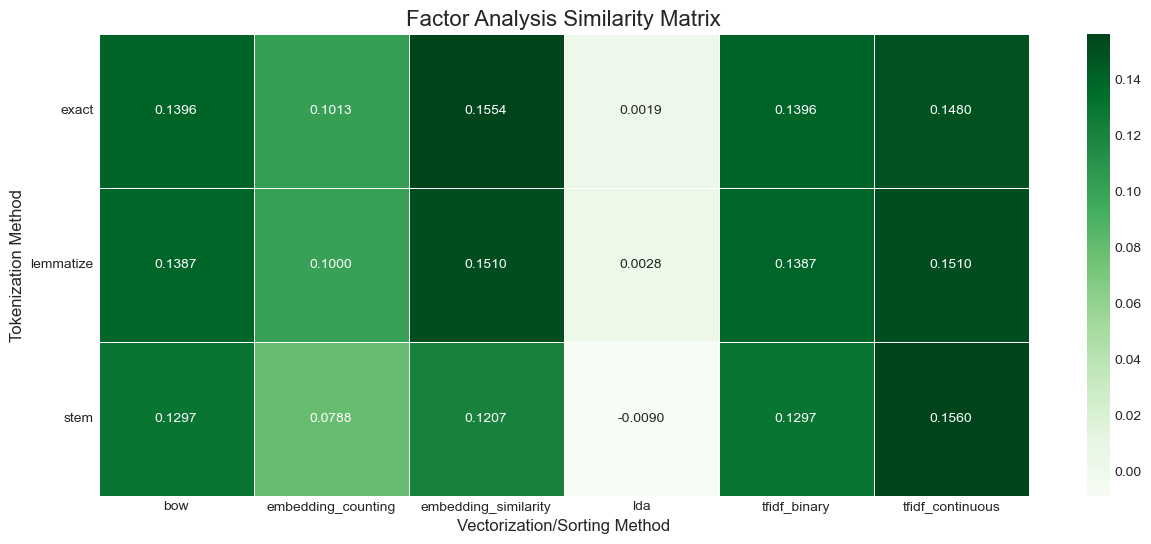

In [35]:
# 绘制因子分析相似度矩阵热力图
# 你可以自由修改这里的参数，如 cmap, annot, fmt 等
pivot_df = results_df.pivot_table(
    index='tokenization', 
    columns='vectorization', 
    values='avg_dimensional_correlation', 
    aggfunc='mean'
)
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="Greens", linewidths=.5) # 示例：修改颜色
plt.title('Factor Analysis Similarity Matrix', fontsize=16)
plt.xlabel('Vectorization/Sorting Method', fontsize=12)
plt.ylabel('Tokenization Method', fontsize=12)
plt.xticks(rotation=0) 
plt.yticks(rotation=0)
plt.show()

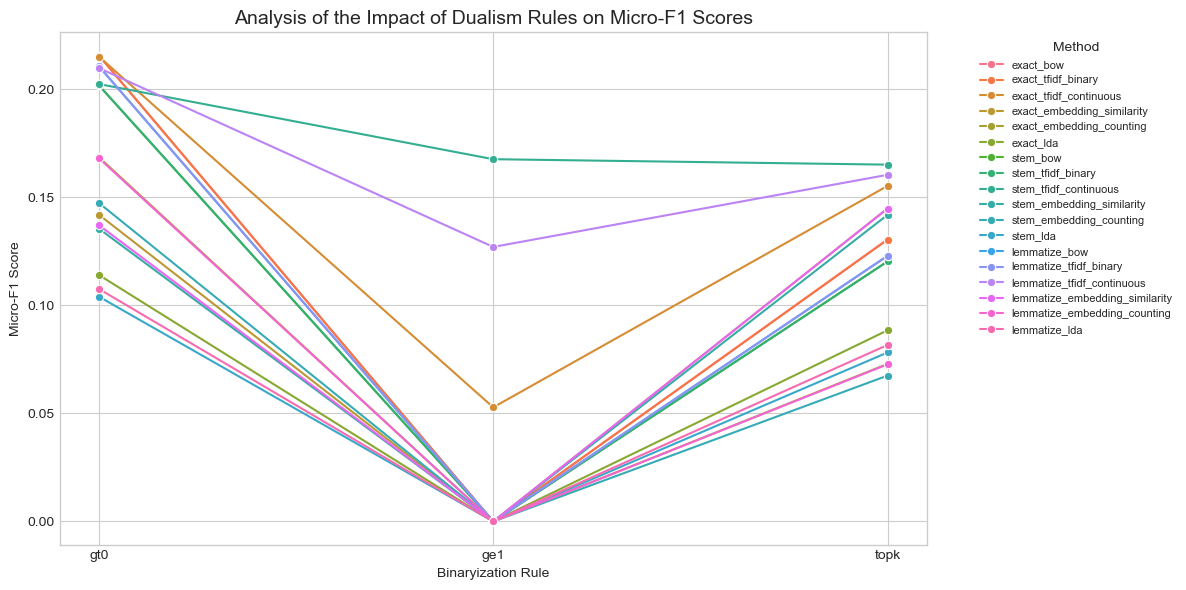

In [37]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
results_df_summary = results_df.dropna(subset=['avg_dimensional_correlation']).copy()
results_df_summary['method'] = results_df_summary['tokenization'] + "_" + results_df_summary['vectorization']
sns.lineplot(data=results_df_summary, x="binarize_rule", y="micro_f1", hue="method", marker="o")
plt.title("Analysis of the Impact of Dualism Rules on Micro-F1 Scores", fontsize=14)
plt.xlabel("Binaryization Rule")
plt.ylabel("Micro-F1 Score")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

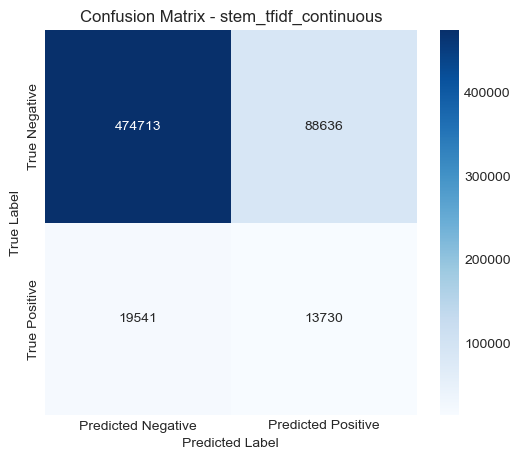

In [39]:
best_model_info = results_df_summary[
    (results_df_summary['tokenization'] == best_config_name.split('_')[0]) &
    (results_df_summary['vectorization'] == '_'.join(best_config_name.split('_')[1:]))
].sort_values(by='micro_f1', ascending=False).iloc[0]

best_binarize_rule = best_model_info['binarize_rule']
best_ipsatised_scores = all_scores[best_config_name]['ipsatised']
expert_ipsatised_scores = ipsatise_scores(expert_scores_df)
_, y_true_best, y_pred_best = evaluate_performance(best_ipsatised_scores, expert_ipsatised_scores, binarize_rule=best_binarize_rule)

cm = confusion_matrix(y_true_best.ravel(), y_pred_best.ravel())
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title(f'Confusion Matrix - {best_config_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

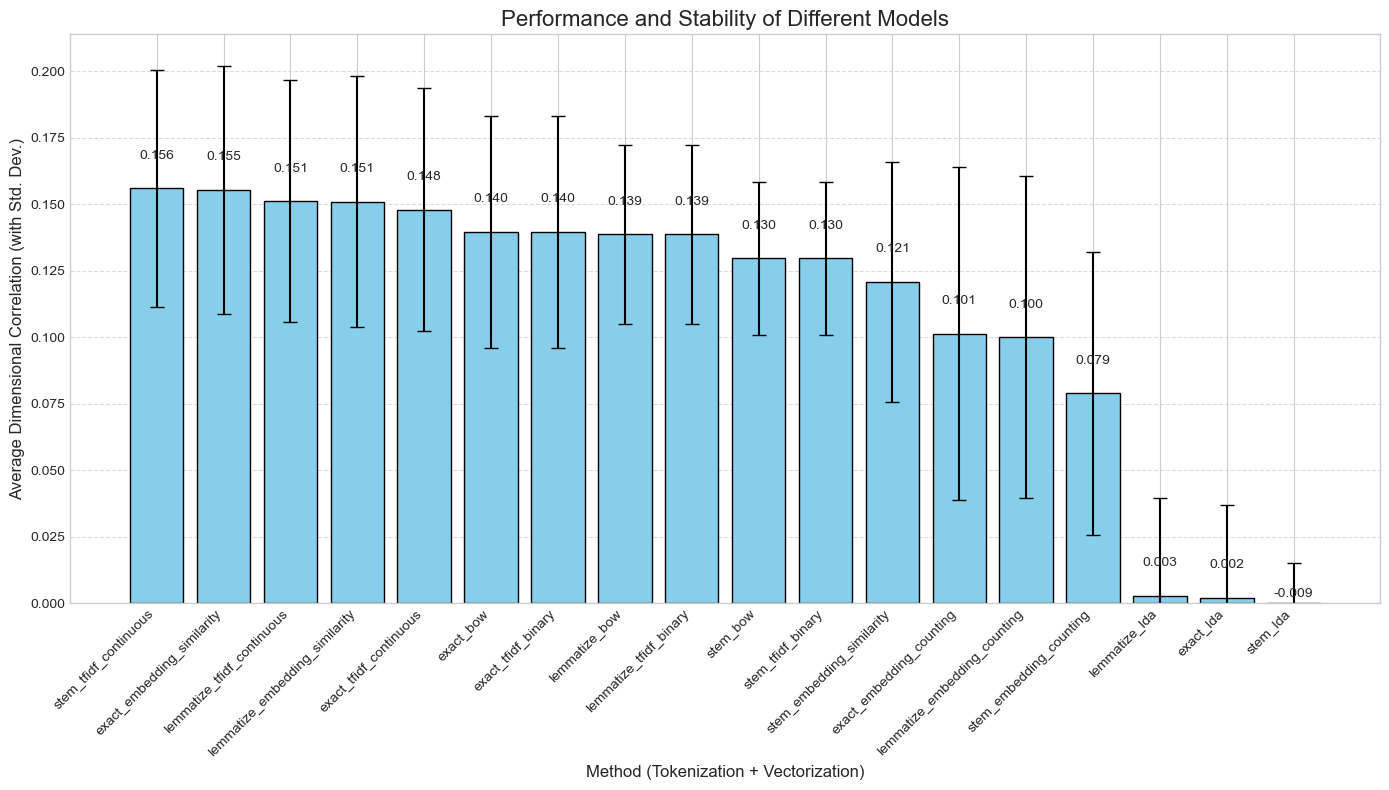

In [ ]:
comparison_df = results_df[results_df['binarize_rule'] == 'gt0'].copy()
comparison_df['method'] = comparison_df['tokenization'] + "_" + comparison_df['vectorization']
comparison_df = comparison_df.sort_values(by='avg_dimensional_correlation', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(
    comparison_df['method'],
    comparison_df['avg_dimensional_correlation'],
    yerr=comparison_df['dimensional_correlation_std'],
    capsize=5, 
    color='skyblue',
    edgecolor='black'
)

plt.ylabel('Average Dimensional Correlation (with Std. Dev.)', fontsize=12)
plt.xlabel('Method (Tokenization + Vectorization)', fontsize=12)
plt.title('Performance and Stability of Different Models', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.show()

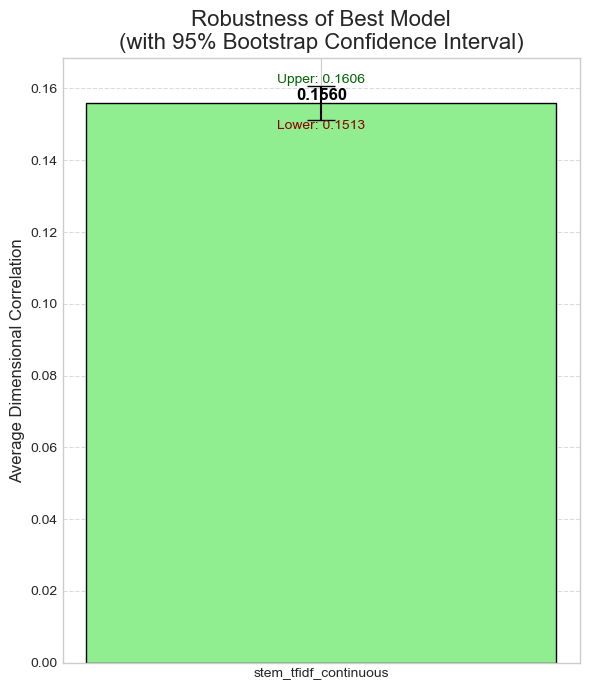

In [ ]:
best_scores_ipsatised = all_scores[best_config_name]['ipsatised']
expert_scores_ipsatised = ipsatise_scores(expert_scores_df)
lower, upper = bootstrap_confidence_intervals(best_scores_ipsatised, expert_scores_ipsatised)


best_corr = results_df[
    (results_df['tokenization'] == best_config_name.split('_')[0]) &
    (results_df['vectorization'] == '_'.join(best_config_name.split('_')[1:]))
]['avg_dimensional_correlation'].mean()


error_margins = [[best_corr - lower], [upper - best_corr]]

plt.figure(figsize=(6, 7))
plt.bar(
    best_config_name,
    best_corr,
    yerr=error_margins,
    capsize=10,
    color='lightgreen',
    edgecolor='black',
    width=0.4
)

plt.ylabel('Average Dimensional Correlation', fontsize=12)
plt.title(f'Robustness of Best Model\n(with 95% Bootstrap Confidence Interval)', fontsize=16)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.text(0, best_corr, f'{best_corr:.4f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
plt.text(0, upper, f'Upper: {upper:.4f}', ha='center', va='bottom', fontsize=10, color='darkgreen')
plt.text(0, lower, f'Lower: {lower:.4f}', ha='center', va='top', fontsize=10, color='darkred')


plt.show()

# Visulization for paper

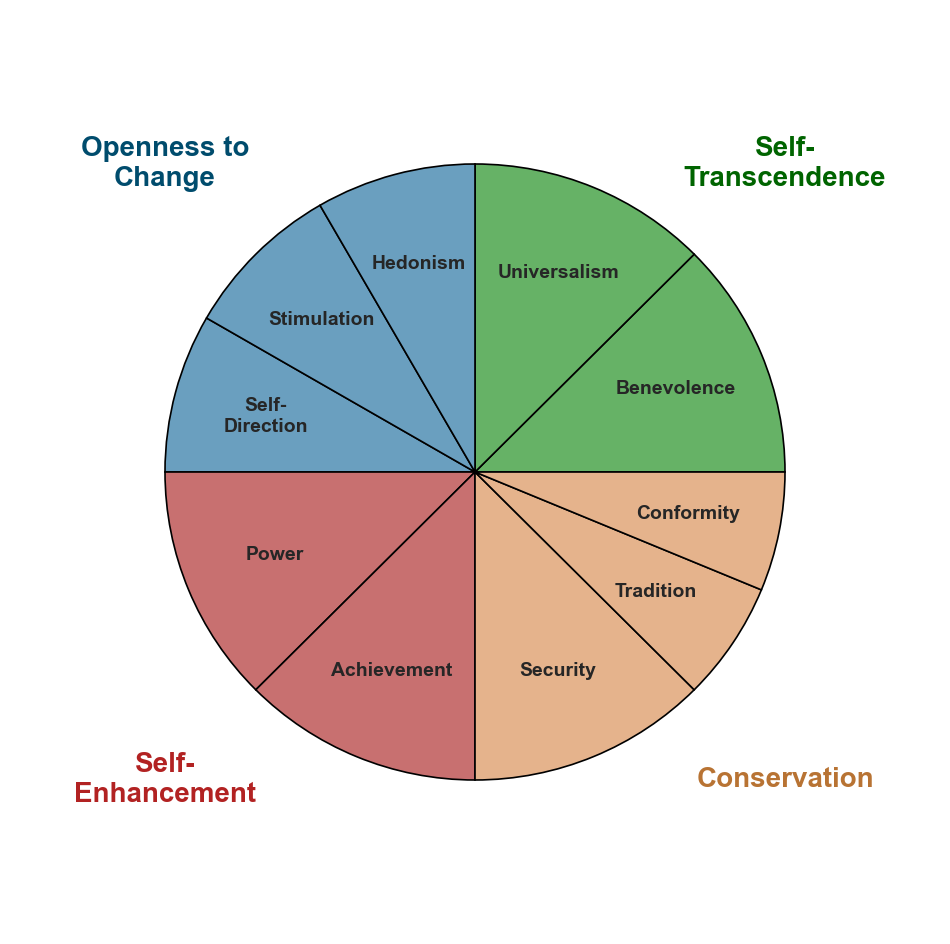

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

values_data = [
    {'label': 'Benevolence', 'start': 0, 'end': 45, 'color': '#66b266'},
    {'label': 'Universalism', 'start': 45, 'end': 90, 'color': '#66b266'},
    
    {'label': 'Self-\nDirection', 'start': 150, 'end': 180, 'color': '#6a9fbf'},
    {'label': 'Stimulation', 'start': 120, 'end': 150, 'color': '#6a9fbf'},
    {'label': 'Hedonism', 'start': 90, 'end': 120, 'color': '#6a9fbf'},

    {'label': 'Power', 'start': 180, 'end': 225, 'color': '#c87070'},
    {'label': 'Achievement', 'start': 225, 'end': 270, 'color': '#c87070'},

    {'label': 'Security', 'start': 270, 'end': 315, 'color': '#e5b38c'},
    {'label': 'Tradition', 'start': 315, 'end': 337.5, 'color': '#e5b38c'},
    {'label': 'Conformity', 'start': 337.5, 'end': 360, 'color': '#e5b38c'},
]

for value in values_data:
    wedge = mpatches.Wedge(
        center=(0, 0),
        r=1, 
        theta1=value['start'],
        theta2=value['end'],
        facecolor=value['color'],
        edgecolor='black',
        linewidth=1.2
    )
    ax.add_patch(wedge)

    mid_angle_rad = np.deg2rad((value['start'] + value['end']) / 2)
    label_radius = 0.7 
    x = label_radius * np.cos(mid_angle_rad)
    y = label_radius * np.sin(mid_angle_rad)
    ax.text(x, y, value['label'], ha='center', va='center', fontsize=14, weight='bold')


quadrant_labels = {
    'Self-\nTranscendence': {'pos': (1 , 1), 'color': '#006400', 'ha': 'center'},
    'Openness to\nChange': {'pos': (-1, 1), 'color': '#004c6d', 'ha': 'center'},
    'Self-\nEnhancement': {'pos': (-1, -1), 'color': '#b22222', 'ha': 'center'},
    'Conservation': {'pos': (1, -1), 'color': '#b87333', 'ha': 'center'}
}

for label, properties in quadrant_labels.items():
    ax.text(properties['pos'][0], properties['pos'][1], label,
            ha=properties['ha'], va='center', fontsize=20, color=properties['color'], weight='bold')

plt.show()